## 《机器学习》课程作业

### 1. Use Proximal Gradient Method (ISTA) and Accelerated Proximal Gradient Method (FISTA) to solve the following convex sparse coding model on your own data (both synthetized and real data are acceptable, but image data is recommended). Show the algorithms, plot the convergence behaviors and compare the speed for these two algorithms.

$$ \min_\beta \frac{1}{2}||X\beta-y||^2+\lambda||\beta||_1$$

where $\beta$ is the sparse code with respect to a given dictionary $X$ and the observation $y$

根据ISTA和FISTA的算法原理，FISTA和ISTA都是基于梯度降落的思想，在迭代进程中进行了更加聪明（smarter）的选择，从而到达更快的迭代速度。理论证明：FISTA和ISTA的迭代收敛速度分别为 $O(1/k^2)$ 和$O(1/k)$。

下面通过简单的实验来验证上面的结论。<br>
1. 随机生成一个10维的特征向量 $X = [x_1, x_2, ..., x_{10}]$
2. 观测值 $y = 2$（也可以设置成其他值，效果一致）
3. 随机生成初始参数向量（稀疏编码）$\beta$,和特征长度相同
4. 根据凸优化问题$ \min_\beta \frac{1}{2}||X\beta-y||^2+\lambda||\beta||_1$求解，其中设$\lambda=1$
5. 实验用Python代码实现了ISTA,FISTA迭代过程
6. 通过不同的步长来并可视化来比较ISTA,FISTA两个算法的差异

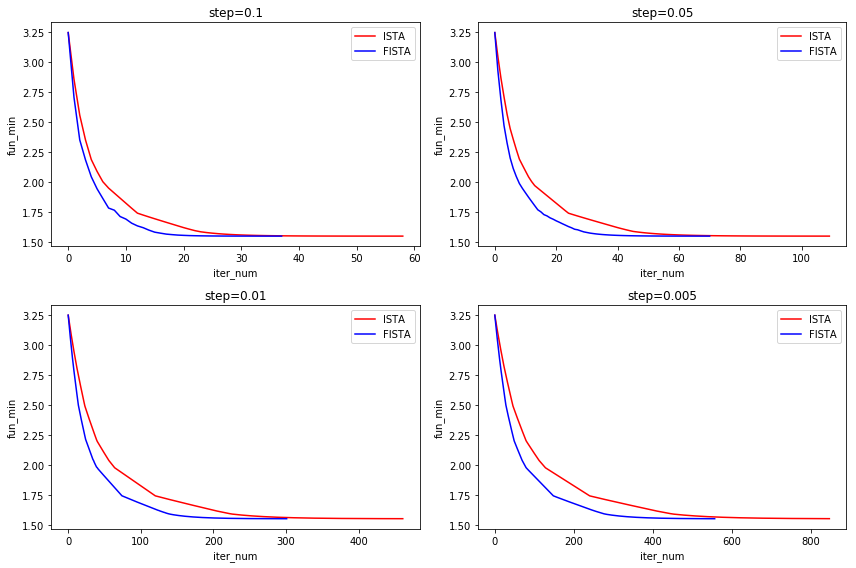

In [147]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

f_len = 10 # 特征向量长度
np.random.seed(51) # 设置随机种子
X = np.random.rand(1, f_len) # 随机生成特征 X
y = 2 # 观测值 y
beta_random = np.random.random((f_len, 1)) # 随机的 beta 值
degree = 0.00001 # 收敛精度

# f(x)
def f(x, y, beta):
    return (x.dot(beta) - y) ** 2 / 2

# df(x)
def derived_f(x, y, beta):
    return x.T.dot(x).dot(beta) - x.T.dot(y)

# g(x)
def g(beta, lmd=1):
    return lmd * sum(abs(beta))

# F(x) = f(x) + g(x)
def F(x, y, beta, lmd=1):
    return f(x, y, beta) + g(beta, lmd)

# proximal_operation
def proximal(x, y, beta, beta_k, lr=0.01, lmd=1):
    z = beta_k - lr * derived_f(x, y, beta_k)
    for i in range(z.shape[0]):
        zi = z[i]
        if lmd * lr < zi:
            z[i] = zi - lmd * lr
        elif zi < - lmd * lr:
            z[i] = zi + lmd * lr
        else:
            z[i] = 0
    return z

def ISTA(X, y, beta, lr=0.05, lmd=1):
    beta_update = beta
    pre = F(X, y, beta_update)[0][0]
    iter_list = []
    iter_list.append(pre)
    while True:
        beta_update = proximal(X, y, beta_random, beta_update, lr=lr,lmd=lmd)
        cur = F(X, y, beta_update)[0][0]
        if np.abs(cur - pre) <= degree:
            break
        iter_list.append(cur)
        pre = cur
    return iter_list

def FISTA(X, y, beta, lr=0.05, lmd=1):
    beta_0 = beta_random
    pre = F(X, y, beta_0)[0][0]
    iter_list = []
    iter_list.append(pre)
    t0 = 1
    while True:
        beta_1 = proximal(X, y, beta_random, beta_0, lr=lr, lmd=lmd)
        t1 = (1 + np.sqrt(1 + 4 * (t0 ** 2))) / 2
        beta_0 = beta_1 + (t0 / t1) * (beta_1 - beta_0)
        cur = F(X, y, beta_0)[0][0]
        if np.abs(cur - pre) <= degree:
            break
        iter_list.append(cur)
        pre = cur
    return iter_list

# 画图
# 不同步长的收敛
steps = [0.1, 0.05, 0.01, 0.005]
plt.figure(figsize=(12, 8))
for i in range(len(steps)):
    step = steps[i]
    ista = ISTA(X, y, beta_random, lr=step)
    fista = FISTA(X, y, beta_random, lr=step)
    plt.subplot(2, 2, i+1)
    l1, = plt.plot(ista, color='r', )
    l2, = plt.plot(fista, color='b')
    plt.title('step={}'.format(step))
    plt.xlabel('iter_num')
    plt.ylabel('fun_min')
    plt.legend([l1, l2], ['ISTA', 'FISTA'])
    plt.tight_layout()
plt.show()

__如上图所示，在不同步长的情况下，FISTA算法的收敛速度要快与ISTA，并且前者迭代次数也要少于后者。__

### 2. Use Smooth Accelerated Proximal Gradient Method (S-FISTA) to solve the following convex image restoration model. Show the algorithm, plot the convergence behaviors and the final performance (qualitatively and quantitatively) for the algorithm.

$$\min_x||Kx-b||^2+\lambda_1||Dx||_1+\lambda_2||x||_1$$

where $x$ is the latent image, $b$ is the noisy observation, $K$ denotes the blur matrix, and $D$ is the gradient operation.

令$f(x)=\cfrac{1}{2}||Kx-b||$,$h(x)=||Dx||_1$,$g(x)=||x||_1$,因为$h(x)=g(Dx)$，对$x$额外做了一步线性运算，无法换成 $prox$ 的形式，但是$h(x)$是$(||D|^2_2||,\frac{p}{2})-smoothable$的，$p$为$x$的维度，因此只要找到$g(x)$的一个$\cfrac{1}{\mu}$光滑近似$g_{\mu}$，将$h(x)$转换成光滑函数，问题即可解。
$$h(x)=g(Dx)\thickapprox g_{\mu}(Dx):=M_{g}^{\mu}(Dx):=\min_{\mu}\{g(u)+\cfrac{1}{2\mu}||\mu-Dx||_2^2\}$$
即：
$$M_g^{\mu}(Dx)=g(u^*)+\cfrac{1}{2\mu}||u^*-Dx||^2_2$$
$$u^*=prox_{\mu, g}(Dx)$$
利用 Moreau Envelope 的性质得：
$$\nabla_xM_g^{\mu}(Dx)=D^T\cdot\cfrac{1}{\mu}(Dx-u^*)=\cfrac{1}{\mu}D^T(Dx-T(Dx, \mu))$$
令$F(x)=f(x)+\lambda_1M_g^{\mu}(x)$，则$\nabla F(x)=\nabla f(x)+\lambda_1\nabla M_g^{\mu}(x)$，原问题转化为：
$$\arg\min_{x} F(x)+\lambda_2g(x)$$

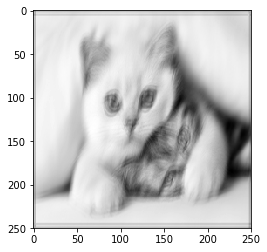

In [139]:
from scipy import signal
import scipy.io as scio
import numpy as np
np.random.seed(2)
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
%matplotlib inline

mat = scio.loadmat('im01_ker01.mat')
ker = mat.get('f') # 获取模糊核心
im = Image.open('./timg.jpg').convert('L')# 原始清晰图像灰度图
im_arr = np.array(im)
blur_im = signal.convolve2d(im_arr, ker, boundary='symm', mode='same') # 根据模糊核模糊图像
plt.imshow(blur_im, cmap='gray') # 显示模糊图像

In [ ]:
function deblur()
clear;
close all;
load('im01_ker01.mat');
[H,W]=size(y);
% dim = opt_fft_size([H,W]+size(f)-1);
dim = [273, 273];
%边界处理
y = wrap_boundary_liu(y, dim);
%将卷积运算转换到傅里叶域
K=psf2otf(f, dim);
KtK=abs(K).^2;
Kty=conj(K).* fft2(y);
%水平和竖直梯度算子
fx = [1, -1];
fy = [1; -1];
otfFx = psf2otf(fx,dim);
otfFy = psf2otf(fy,dim);
FtF = abs(otfFx).^2 + abs(otfFy ).^2;

s=y;%需要估计的清晰图像
miu=0.1;
L=0.5;%这里使用了固定步长
MAX_ITER=100;
lambda1=0.002;
lambda2=0.002;

s=y;
t0=1;
zpre=s;
for k = 1:MAX_ITER
    %梯度运算
    h = [diff(s,1,2), s(:,1,:) - s(:,end,:)];
    v = [diff(s,1,1); s(1,:,:) - s(end,:,:)];
    h = soft_threshold(h, miu*lambda1);
    v = soft_threshold(v, miu*lambda1);
    %共轭后的梯度运算，公式中的Dt部分
    g = [h(:, end, :) - h(:, 1, :), -diff(h,1,2)];
    g = g + [v(end, :, :) - v(1, :, :); -diff(v,1,1)];

    S=fft2(s);
    grad_x=real(ifft2( KtK.*S-Kty + (1.0/miu) *(FtF.*S- fft2(g)) ));
    
    z=soft_threshold(s - L*grad_x, lambda2);
    
    t1=0.5+0.5*sqrt(1+4*t0*t0);
    s=z+(t0-1)/t1*(z-zpre);
    zpre=z;
    t0=t1;
    %计算PSNR
    PSNR_fista(k)=psnr(s(1:H, 1:W, :),x);
end
s = s(1:H, 1:W, :);
figure(1);imshow(s,[]);
figure(2);hold on;
plot(PSNR_fista,'LineWidth',2);
ylabel('PSNR','FontSize',18);
xlabel('Iterations','FontSize',18);
title('S-FISTA','FontSize',18)
end

function [X]=soft_threshold(b,lambda)
  X=sign(b).*max(abs(b) - lambda, 0);
end

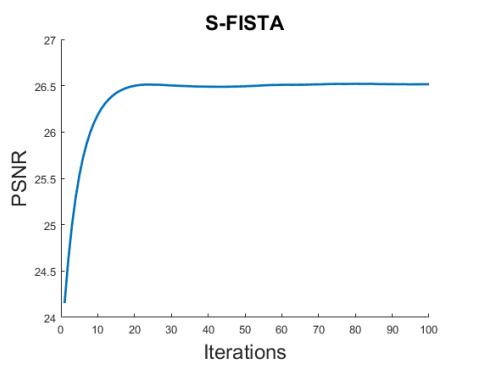

### 3. Use Proximal Alternating Linearized Minimization (PALM) to solve the following nonconvex nonnegative matrix factorization model on your own data (both synthetized and real data are acceptable, but image data is recommended). Show the algorithm and plot the convergence behaviors for the algorithm.

$$\min_{A\ge0,B\ge0}\frac{1}{2}||X-AB||^2$$

where $X$ is the observation and $A$ and $B$ are two unknown nonnegative component matrices.

令$J=\cfrac{1}{2}||X-AB||^2_2$, $\cfrac{\partial J}{\partial A}=(X-AB)B^T$,$\cfrac{\partial J}{\partial B}=A^T(X-AB)$<br>
接下来使用梯度下降法进行迭代
$$A^+=A-\alpha_1\cdot(XB^T-ABB^T)$$
$$B^+=B-\alpha_2\cdot(A^TX-A^TAB)$$
即：
$$A^+=A\odot(1-\alpha_1\cdot\cfrac{XB^T}{A}+\alpha_1\cdot\cfrac{ABB^T}{A})$$
$$B^+=B\odot(1-\alpha_2\cdot\cfrac{A^TX}{B}+\alpha_2\cdot\cfrac{A^TAB}{B})$$
如果选取
$$\alpha_1=-\cfrac{A}{AAB^T}$$
$$\alpha_2=-\cfrac{B}{A^TAB}$$
其中除法为对应元素相处，$\odot$为对应元素相乘，那么最终的迭代式为
$$A^+=A\odot(1+\cfrac{A}{AAB^T}\odot\cfrac{XB^T}{A}-1)=A\odot(\cfrac{XB^T}{ABB^T})$$
$$B^+=B\odot(1+\cfrac{B}{A^TAB}\cdot\cfrac{A^TX}{B}-1)=B\odot(\cfrac{A^TX}{A^TAB})$$
可以看出这是乘性迭代规则，每一步都保证了结果为正数，根据PALM算法可知一直迭代下去就会收敛。

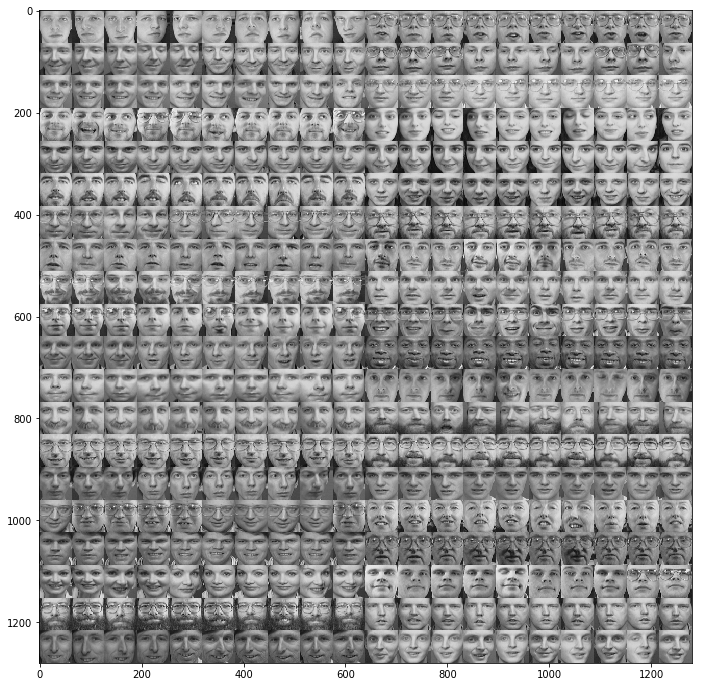

In [140]:
import os
import numpy as np
from PIL import Image
import scipy.io as scio
import matplotlib.pyplot as plt
%matplotlib inline

# 加载数据 ORL 数据集
orl = scio.loadmat('./ORL.mat')
label = orl.get('gnd')
X = orl.get('fea')
imgs_arr = X.reshape((400, 64, 64))

imgs = []
for img_arr in imgs_arr:
    im = Image.fromarray(img_arr)
    im = im.rotate(270)
    imgs.append(np.array(im))

imgs_arr = np.array(imgs)
X = imgs_arr.reshape(400, 64*64)
img_show = np.zeros((20*64, 20*64))
for i in range(20):
    for j in range(20):
        img_show[i*64:i*64+64,j*64:j*64+64] = imgs_arr[i*20+j]
plt.figure(figsize=(12, 12))
plt.imshow(img_show, cmap='gray') # 显示原始图

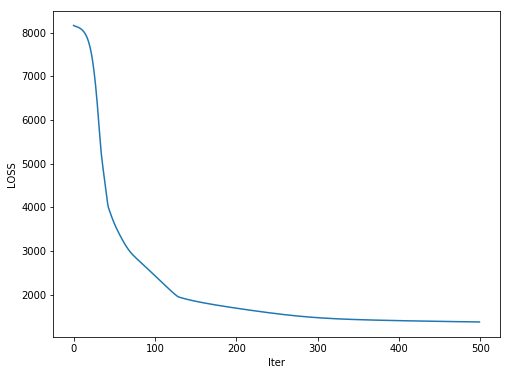

In [141]:
class_num = len(np.unique(label))

m, n = X.shape

np.random.seed(50) # 设置随机种植
A = np.random.random((m, class_num))
B = np.random.random((class_num, n))

losses = [] # 存储迭代过程loss变化

for _ in range(500):
    A = A * ((X.dot(B.T)) / (A.dot(B).dot(B.T)))
    B = B * ((A.T.dot(X)) / (A.T.dot(A).dot(B)))
    loss = np.linalg.norm(X - A.dot(B), 2) / 2 
    losses.append(loss)

# 画收敛曲线
plt.figure(figsize=(8, 6))
plt.xlabel('Iter')
plt.ylabel('LOSS')
plt.plot(losses)

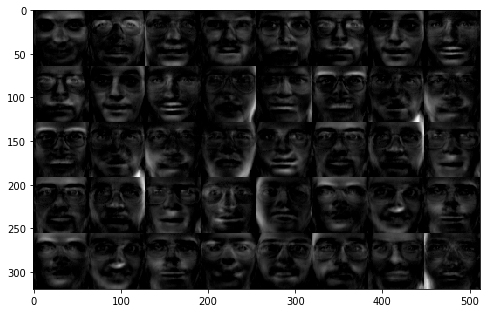

In [142]:
B = B.reshape((40, 64, 64))
feature_show = np.zeros((5*64, 8*64))
for i in range(5):
    for j in range(8):
        feature_show[i*64:i*64+64,j*64:j*64+64] = B[i*5+j]
plt.figure(figsize=(8, 6))
plt.imshow(feature_show, cmap='gray') # 显示原始图